<a href="https://colab.research.google.com/github/Christopher-Mao/AI-Practicum/blob/main/Newer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Constants used below:
# Set a custom sampling strategy (e.g., 0.25 means the minority class will be 25% of the majority class)
sampling_ratio = 0.25  # Adjust this value as needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

num_epochs = 2

seq_length = 5  # however long you want the training sequence to be

hidden_size = 50  # Number of hidden units
num_layers = 2  # Number of stacked LSTM layers

In [3]:
!wget https://www.epa.gov/system/files/other-files/2023-08/ucmr5-occurrence-data.zip
!unzip ucmr5-occurrence-data.zip

--2024-12-08 03:51:40--  https://www.epa.gov/system/files/other-files/2023-08/ucmr5-occurrence-data.zip
Resolving www.epa.gov (www.epa.gov)... 13.32.99.93, 13.32.99.101, 13.32.99.3, ...
Connecting to www.epa.gov (www.epa.gov)|13.32.99.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8128843 (7.8M) [application/zip]
Saving to: ‘ucmr5-occurrence-data.zip.2’

ucmr5-occurrence-da 100%[===================>]   7.75M  5.56MB/s    in 1.4s    

2024-12-08 03:51:43 (5.56 MB/s) - ‘ucmr5-occurrence-data.zip.2’ saved [8128843/8128843]

Archive:  ucmr5-occurrence-data.zip
replace UCMR5_ZIPCodes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
def text_to_pandas(file_path, sep='\t', encoding='latin-1'):
    df = pd.read_csv(file_path, sep=sep, encoding=encoding)
    return df
UCMR5_df = text_to_pandas('UCMR5_All.txt')

## Preprocessing

In [5]:
print(UCMR5_df.shape)
# Drop unnecessary row 'lithium'
UCMR5_filtered_df = UCMR5_df[~UCMR5_df['Contaminant'].str.contains('lithium', case=False, na=False)].copy()
print(UCMR5_filtered_df.shape)

(1133967, 24)
(1095477, 24)


In [6]:
UCMR5_filtered_df = UCMR5_filtered_df[['Size', 'FacilityWaterType', 'CollectionDate', 'Contaminant', 'MRL', 'AnalyticalResultsSign', 'AnalyticalResultValue', 'Region']].copy()
UCMR5_filtered_df.shape

(1095477, 8)

In [7]:
# Convert 'CollectionDate' to datetime objects, handling potential errors
UCMR5_filtered_df['CollectionDate'] = pd.to_datetime(UCMR5_filtered_df['CollectionDate'], errors='coerce')
UCMR5_filtered_df['Year'] = UCMR5_filtered_df['CollectionDate'].dt.year
UCMR5_filtered_df['Month'] = UCMR5_filtered_df['CollectionDate'].dt.month
UCMR5_filtered_df['Day'] = UCMR5_filtered_df['CollectionDate'].dt.day
UCMR5_filtered_df['Quarter'] = UCMR5_filtered_df['CollectionDate'].dt.quarter

In [8]:
print("Range of CollectionDate in UCMR5_filtered_df:")
print(UCMR5_filtered_df['CollectionDate'].min(), UCMR5_filtered_df['CollectionDate'].max())

Range of CollectionDate in UCMR5_filtered_df:
2023-01-03 00:00:00 2024-09-30 00:00:00


## LSTM Model

In [9]:
# Check CUDA availability
print(f"Using device: {device}")

Using device: cuda


1. Filter Data for Training and Prediction
Training Data: Include only rows from 2023.
Test Data (Prediction): Include only rows from 2024.

In [10]:
# Filter training and prediction datasets
train_data = UCMR5_filtered_df[UCMR5_filtered_df["Year"] == 2023]
test_data = UCMR5_filtered_df[UCMR5_filtered_df["Year"] == 2024]

# Separate features and target variable
features = ['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region']
target = 'AnalyticalResultsSign'

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]

2. Preprocess the Data
One-Hot Encoding and Normalization
Ensure the test data (2024) uses the same encoding and normalization as the training data:

In [11]:
# One-hot encode categorical features
X_train = pd.get_dummies(X_train, columns=['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region'], drop_first=True)
# Ensure both datasets have the same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
# Convert target to binary values
y_train = (y_train == '=').astype(int)  # 1 for '=', 0 for '<'
# Normalize or standardize features (optional)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

3. Apply SMOTE or undersampling

In [12]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE with the custom sampling ratio
smote = SMOTE(sampling_strategy=sampling_ratio, random_state=42)  # Set random_state for reproducibility
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution before and after applying SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())



# # Undersampling
# from imblearn.under_sampling import RandomUnderSampler

# # Apply undersampling to training data
# undersampler = RandomUnderSampler(random_state=42)  # Set random_state for reproducibility
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# # Print the class distribution before and after applying undersampling
# print("Class distribution before undersampling:")
# print(pd.Series(y_train).value_counts())
# print("\nClass distribution after undersampling:")
# print(pd.Series(y_train_resampled).value_counts())



Class distribution before SMOTE:
AnalyticalResultsSign
0    603961
1     13120
Name: count, dtype: int64

Class distribution after SMOTE:
AnalyticalResultsSign
0    603961
1    150990
Name: count, dtype: int64


4. Convert Data to PyTorch Tensors

In [13]:
# Define sequence length


# Reshape X_train and y_train into sequences
X_train_sequences = []
y_train_sequences = []

# Convert X_train and y_train into overlapping sequences
for i in range(len(X_train) - seq_length + 1):
    # Collect seq_length timesteps for input
    X_train_sequences.append(X_train_resampled[i:i+seq_length, :])
    # Use the value after the sequence as the target
    y_train_sequences.append(y_train_resampled.values[i + seq_length - 1])

# Convert sequences to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)  # Shape: (num_samples, seq_length, num_features)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)  # Shape: (num_samples,)

# Optionally repeat the process for X_test if necessary
X_test_sequences = []
for i in range(len(X_test) - seq_length + 1):
    X_test_sequences.append(X_test[i:i+seq_length, :])
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)

# Create DataLoader for training
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Optional: Check shapes for debugging
print(f"X_train_tensor shape: {X_train_tensor.shape}")  # (num_samples, seq_length, num_features)
print(f"y_train_tensor shape: {y_train_tensor.shape}")  # (num_samples,)


<ipython-input-13-5239a98059e1>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)  # Shape: (num_samples, seq_length, num_features)


X_train_tensor shape: torch.Size([617077, 5, 82])
y_train_tensor shape: torch.Size([617077])


In [14]:
# --- Step 3: Define the LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for regression

        # Initialize hidden and cell states as None
        self.hidden = None

    def forward(self, x):
        # If hidden states are None or the batch size changes, reinitialize them
        if self.hidden is None or self.hidden[0].size(1) != x.size(0):
            self.hidden = (
                torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device),
                torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device),
            )

        # Forward propagate through LSTM
        out, self.hidden = self.lstm(x, self.hidden)

        # Detach hidden states to prevent backprop through history
        self.hidden = (self.hidden[0].detach(), self.hidden[1].detach())

        # Fully connected layer on the last time step
        out = self.fc(out[:, -1, :])
        return out


    def reset_hidden_state(self):
        """Reset hidden and cell states (e.g., at the start of each epoch)."""
        self.hidden = None


In [15]:
# --- Step 4: Initialize the Model, Loss Function, and Optimizer ---

input_size = X_train_tensor.shape[2]  # Number of features. tensor is num_samples, seq_length, num_features

model = LSTMModel(input_size, hidden_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Optimizer

In [16]:
from tqdm import tqdm
import time

# --- Step 5: Train the Model ---

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Reset hidden state at the start of each epoch (if needed)
    if hasattr(model, "reset_hidden_state"):
        model.reset_hidden_state()

    # Use tqdm to create a progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for X_batch, y_batch in pbar:
            start_time = time.time()  # Start time for the batch

            # Move data to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()

            # End time for the batch
            batch_time = time.time() - start_time

            # Update tqdm description
            pbar.set_postfix(loss=f"{loss.item():.4f}", batch_time=f"{batch_time:.4f}s")

    # Print epoch-level results
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.8f}")

Epoch 1/2: 100%|██████████| 19284/19284 [02:18<00:00, 139.53batch/s, batch_time=0.0091s, loss=-0.0000]


Epoch [1/2], Loss: 1.54392877


Epoch 2/2: 100%|██████████| 19284/19284 [02:08<00:00, 150.64batch/s, batch_time=0.0040s, loss=6.4825]

Epoch [2/2], Loss: 1.28843333


In [17]:
from sklearn.metrics import confusion_matrix

# --- Step 6: Make Predictions for 2024 ---
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    print(f"Original X_test_tensor shape: {X_test_tensor.shape}")  # Debug
    X_test_tensor = X_test_tensor.to(device)  # Add time dimension and move to device
    print(f"Reshaped X_test_tensor shape: {X_test_tensor.shape}")  # Debug

    # Get model predictions
    outputs = model(X_test_tensor)  # Raw logits or probabilities
    predictions = torch.sigmoid(outputs).squeeze()  # Apply sigmoid for binary classification probabilities

# Convert probabilities to binary class labels
threshold = 0.5
predicted_labels = (predictions > threshold).int()  # Convert probabilities to 0 or 1

# Ensure alignment by dropping initial rows from test_data
adjusted_test_data = test_data.iloc[seq_length - 1:].copy()

# Add predictions to the adjusted DataFrame
adjusted_test_data["PredictedSign"] = predicted_labels.cpu().numpy()

# Save the results
adjusted_test_data.to_csv("predictions_2024.csv", index=False)

# Debugging: Check alignment
print(f"Adjusted test_data shape: {adjusted_test_data.shape}")
print(f"PredictedSign shape: {predicted_labels.shape}")

# --- Optional: Evaluate the Model ---
if 'AnalyticalResultsSign' in test_data.columns:
    y_test = adjusted_test_data['AnalyticalResultsSign'].values
    y_test_binary = (y_test == '=').astype(int)  # Convert ground truth to binary labels

    # Convert ground truth to PyTorch tensor
    y_test_tensor = torch.tensor(y_test_binary, dtype=torch.float32).to(device)

    # Ensure alignment
    if len(predicted_labels) != len(y_test_tensor):
        raise ValueError("Mismatch between predictions and ground truth values.")

    # Calculate accuracy
    correct_predictions = (predicted_labels == y_test_tensor).sum().item()
    accuracy = correct_predictions / len(y_test_tensor)

    print(f"Accuracy on 2024 data: {accuracy:.4f}")

    # Additional metrics (e.g., precision, recall, F1-score)
    from sklearn.metrics import classification_report
    print(classification_report(y_test_binary, predicted_labels.cpu().numpy()))

    # --- Add Confusion Matrix ---
    from sklearn.metrics import confusion_matrix

    # Assuming y_test_binary and predicted_labels are defined as in your code
    conf_matrix = confusion_matrix(y_test_binary, predicted_labels.cpu().numpy())

    print("Confusion Matrix:")
    print(conf_matrix)

Original X_test_tensor shape: torch.Size([478392, 5, 82])
Reshaped X_test_tensor shape: torch.Size([478392, 5, 82])
Adjusted test_data shape: (478392, 13)
PredictedSign shape: torch.Size([478392])
Accuracy on 2024 data: 0.7419
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    469166
           1       0.07      0.98      0.13      9226

    accuracy                           0.74    478392
   macro avg       0.53      0.86      0.49    478392
weighted avg       0.98      0.74      0.83    478392

Confusion Matrix:
[[345862 123304]
 [   175   9051]]


In [18]:
# --- Step 1: Filter Data ---
filtered_data = adjusted_test_data[adjusted_test_data["PredictedSign"] == 1].copy()
filtered_data["AnalyticalResultValue"].fillna(
    filtered_data["MRL"] / 2, inplace=True
)

# Features and target
features = ['Size', 'FacilityWaterType', 'Month', 'Day', 'Contaminant', 'Region']
target = 'AnalyticalResultValue'

# Debug: Check if features exist in UCMR5_filtered_df
missing_features = [col for col in features if col not in UCMR5_filtered_df.columns]
if missing_features:
    print(f"Missing feature columns: {missing_features}")
    raise ValueError("Features are missing from the dataset.")

# Training data
filtered_train = UCMR5_filtered_df[
    (UCMR5_filtered_df['AnalyticalResultsSign'] == '=') &
    (UCMR5_filtered_df['Year'] == 2023)
]
if filtered_train.empty:
    raise ValueError("No rows match the filtering criteria for training data.")
# Impute missing AnalyticalResultValue with MRL / 2 in the training data
filtered_train["AnalyticalResultValue"].fillna(
    filtered_train["MRL"] / 2, inplace=True
)

X_train_reg = filtered_train[features]
y_train_reg = filtered_train[target]

# Test data
X_test_reg = filtered_data[features]
y_test_reg = filtered_data[target] if target in filtered_data.columns else None

# Debug: Check if train/test data have rows
print(f"X_train_reg shape: {X_train_reg.shape}")
print(f"X_test_reg shape: {X_test_reg.shape}")
if X_train_reg.empty:
    raise ValueError("X_train_reg is empty after filtering.")
if X_test_reg.empty:
    raise ValueError("X_test_reg is empty after filtering.")

# --- Step 2: One-Hot Encode Categorical Variables ---
X_train_reg = pd.get_dummies(X_train_reg, columns=features, drop_first=True)
X_test_reg = pd.get_dummies(X_test_reg, columns=features, drop_first=True)

# Align test set columns with training set
X_test_reg = X_test_reg.reindex(columns=X_train_reg.columns, fill_value=0)

# --- Step 3: Normalize Features ---
# Check for empty DataFrames before normalization
if X_train_reg.shape[1] == 0 or X_test_reg.shape[1] == 0:
    raise ValueError("No features available after one-hot encoding.")

scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)


<ipython-input-18-b9c4d4c24e2d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_data["AnalyticalResultValue"].fillna(
<ipython-input-18-b9c4d4c24e2d>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

X_train_reg shape: (13120, 6)
X_test_reg shape: (132355, 6)


In [19]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Single output for regression

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output of the last LSTM cell
        return out


In [20]:
# Define sequence length
seq_length = 5

# Prepare training sequences
X_train_sequences = []
y_train_sequences = []

for i in range(len(X_train_reg) - seq_length + 1):
    X_train_sequences.append(X_train_reg[i:i+seq_length, :])
    y_train_sequences.append(y_train_reg.values[i + seq_length - 1])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)

# Prepare test sequences
X_test_sequences = []

for i in range(len(X_test_reg) - seq_length + 1):
    X_test_sequences.append(X_test_reg[i:i+seq_length, :])

X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)


In [21]:
# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[2]
hidden_size = 50
num_layers = 2
model = LSTMRegressor(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()  # Loss function for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for i in range(0, len(X_train_tensor), 32):  # Mini-batches
        X_batch = X_train_tensor[i:i+32].to(device)
        y_batch = y_train_tensor[i:i+32].to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (len(X_train_tensor) // 32):.4f}")


Epoch [1/20], Loss: 0.0006
Epoch [2/20], Loss: 0.0004
Epoch [3/20], Loss: 0.0004
Epoch [4/20], Loss: 0.0004
Epoch [5/20], Loss: 0.0004
Epoch [6/20], Loss: 0.0003
Epoch [7/20], Loss: 0.0003
Epoch [8/20], Loss: 0.0003
Epoch [9/20], Loss: 0.0002
Epoch [10/20], Loss: 0.0002
Epoch [11/20], Loss: 0.0002
Epoch [12/20], Loss: 0.0001
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0001
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0001
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0001


In [22]:
# Predict for test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device)).squeeze().cpu().numpy()

# Save predictions
# Drop the first `seq_length - 1` rows from filtered_data to align with predictions
adjusted_filtered_data = filtered_data.iloc[seq_length - 1:].copy()

# Ensure alignment
if len(predictions) != len(adjusted_filtered_data):
    raise ValueError("Mismatch between predictions and filtered_data rows after adjustment.")

# Add predictions to the adjusted DataFrame
adjusted_filtered_data["PredictedAnalyticalResultValue"] = predictions

# Save results
adjusted_filtered_data.to_csv("predicted_analytical_result_values.csv", index=False)

# Print sample results
print(adjusted_filtered_data[["PredictedSign", "PredictedAnalyticalResultValue"]].head())

    PredictedSign  PredictedAnalyticalResultValue
79              1                        0.008808
82              1                        0.007580
83              1                        0.010001
86              1                        0.012596
88              1                        0.008119


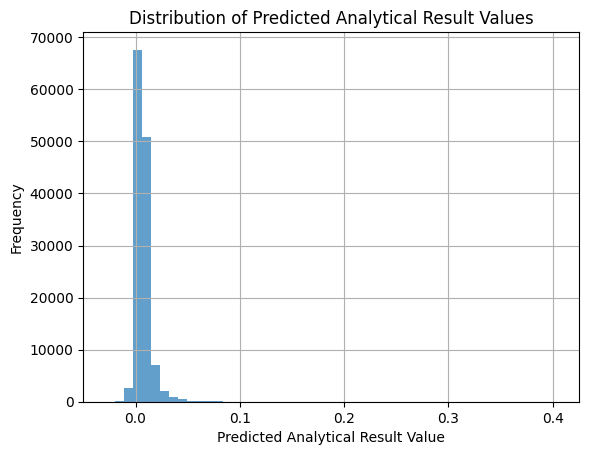

In [23]:
import matplotlib.pyplot as plt

# Histogram of predicted values
plt.hist(adjusted_filtered_data["PredictedAnalyticalResultValue"], bins=50, alpha=0.7)
plt.title("Distribution of Predicted Analytical Result Values")
plt.xlabel("Predicted Analytical Result Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_actual = adjusted_filtered_data["AnalyticalResultValue"].values
y_pred = adjusted_filtered_data["PredictedAnalyticalResultValue"].values

mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")


MSE: 0.0002, MAE: 0.0061
